## Классификация изображений с помощью глубоких сверточных нейронных сетей

Слои CNN способны автоматически выявлять в сырых данных признаки, которые наиболее полезны для отдельно взятой задачи. По этой причине слои CNN
принято считать средствами выделения признаков: начальные слои (находящиеся сразу после входного слоя) извлекают низкоуровневые признаки
из сырых данных, а более поздние слои (зачастую полносвяные слои вроде
имеющихся в многослойном персептроне) используют такие признаки для
прогнозирования непрерывного целевого значения или метки класса. 


#### Одномерная дискретная свертка

Дискретная свертка для 2-ух одномерных векторов x (вход) и w (ядро) обозначается как y=x*w.

Вектор x дополняется конечным числом нулей - это назывыется дополнение (p).

<img src="pic/convpad.png"/>


Смещение фильтра w по входному сигналу x называется страйдом (s).
<img src="pic/conv.png"/>

В сверточных нейронных сетях наиболее распространено одинаковое дополнение. Одно из преимуществ данного режима по сравнению с другими
заключается в том, что одинаковое дополнение предохраняет размер вектора
(или высоту и ширину входных изображений при обработке задач компьютерного зрения), повышая удобство проектирования архитектуры сети.
Крупный недостаток допустимого дополнения в сравнении с полным и
одинаковым дополнением, состоит в том, что в нейронных сетях с множеством слоев объем тензоров значительно уменьшается, и это может пагубно
сказаться на эффективности сети.
На практике рекомендуется предохранять пространственный размер, используя одинаковое дополнение для сверточных слоев, и взамен уменьшать
пространственный размер посредством объединяющих слоев.

Размер выхода свертки определяется общим количеством сдвигов фильтра w вдоль входного вектора. Пусть входной вектор имеет размер n, а
фильтр - размер m. Тогда размер выхода из у = х * w с дополнением р и
страйдом s определяется следующим образом: 
<img src="pic/sizeconvout.png"/>, где |_._| - операция округления в меньшую сторону. 

In [1]:
# вычисление свертки в одном измерении
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s), s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))

    return np.array(res)

x = [1, 2, 3, 5, 1, 4, 6, 9]
w = [1, 0, 5, 2, 7]
print('conv1d:', conv1d(x, w, p=2, s=1))
print('numpy func:', np.convolve(x, w, mode='same'))

conv1d: [ 8. 17. 27. 49. 42. 66. 45. 85.]
numpy func: [ 8 17 27 49 42 66 45 85]


#### Дискретная свертка в двух измерениях

<img src="pic/conv2d.png" width="400">

Поворот - это не транспонирование матрицы.
Это W[::-1, ::-1].

<img src="pic/example_conv2d.png">

In [2]:
# вычисление свертки в двух измерениях
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1, ::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
             p[1]:p[1]+X_orig.shape[1]] = X_orig
    res = []
    for i in range(0, int(X_padded.shape[0] - W_rot.shape[0]/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int(X_padded.shape[1] - W_rot.shape[1]/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return np.array(res)

X = np.random.randint(5, size=(4, 4))
W = np.random.randint(4, size=(3, 3))
print(f'X:\n{X}\nW:\n{W}')
print('conv2d:\n', conv2d(X, W, p=(1, 1), s=(1, 1)))
print('scipy func:\n', scipy.signal.convolve2d(X, W, mode='same'))

X:
[[3 2 3 0]
 [3 4 4 3]
 [2 0 3 4]
 [0 3 3 4]]
W:
[[0 0 2]
 [3 2 1]
 [2 1 1]]
conv2d:
 [[12. 22. 16. 11.]
 [25. 38. 26. 19.]
 [15. 26. 38. 24.]
 [11. 23. 32. 18.]]
scipy func:
 [[12 22 16 11]
 [25 38 26 19]
 [15 26 38 24]
 [11 23 32 18]]


In [3]:
from PIL import Image

In [4]:
pic = np.asarray(Image.open('./pic.jpg'))
W = [[0.01, 0.01, 0.01],
     [0.01, -1.5, 0.01],
     [0.01, 0.01, 0.01]]

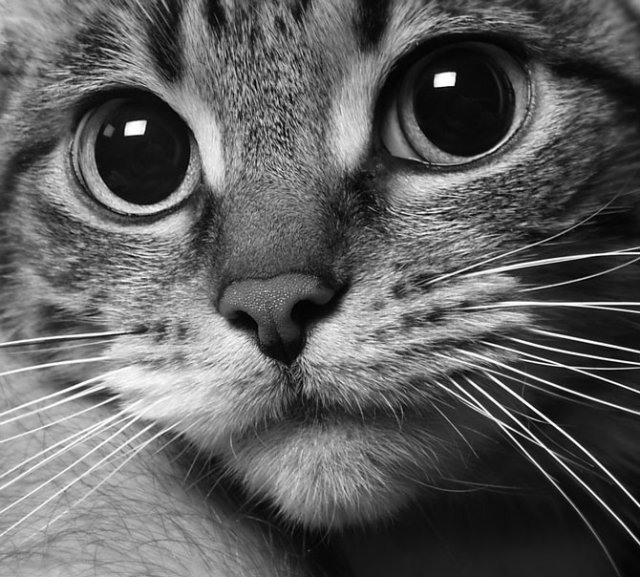

In [5]:
PIL_image = Image.fromarray(pic.astype('uint8'), 'RGB')
PIL_image

In [6]:
pic[:, :, 0] = conv2d(pic[:, :, 0], W, p=(1, 1), s=(1, 1))
pic[:, :, 1] = conv2d(pic[:, :, 1], W, p=(1, 1), s=(1, 1))
pic[:, :, 2] = conv2d(pic[:, :, 2], W, p=(1, 1), s=(1, 1))

In [7]:
PIL_image = Image.fromarray(pic.astype('uint8'), 'RGB')

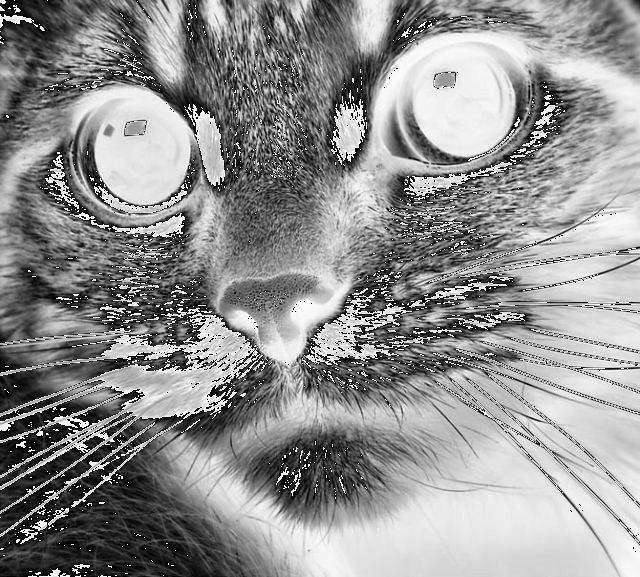

In [8]:
PIL_image

#### Слои подвыборки (объединение)

В сверточных нейронных сетях подвыборка, как правило, применяется
в двух формах операций объединения: объединение по максимуму (max-pooling) и объединеиие по среднему (mean-pooling или average-pooling).

<img src='pic/pooling.png' width='430'>

Преимущество объединения двояко.
- Объединение (по максимуму) привносит локальную инвариантность. Это означает, что небольшие изменения в локальной близлежащей области не изменяют результат объединения по максимуму. Следовательно, инвариантность помогает генерировать признаки, более устройчивые к шуму во входных данных.
- Объединение уменьшает размер признаков, что в результате приводит к более высокой вычислительной эффективности. Также уменьшается степень переобучения.

In [12]:
# работа с изображениями

import tensorflow as tf

img_raw = tf.io.read_file('pic.jpg')
img = tf.image.decode_image(img_raw)
img

<tf.Tensor: shape=(577, 640, 3), dtype=uint8, numpy=
array([[[195, 195, 195],
        [194, 194, 194],
        [197, 197, 197],
        ...,
        [155, 155, 155],
        [155, 155, 155],
        [160, 160, 160]],

       [[191, 191, 191],
        [190, 190, 190],
        [188, 188, 188],
        ...,
        [152, 152, 152],
        [152, 152, 152],
        [158, 158, 158]],

       [[178, 178, 178],
        [183, 183, 183],
        [184, 184, 184],
        ...,
        [147, 147, 147],
        [147, 147, 147],
        [153, 153, 153]],

       ...,

       [[153, 153, 153],
        [155, 155, 155],
        [157, 157, 157],
        ...,
        [  6,   6,   6],
        [  7,   7,   7],
        [  7,   7,   7]],

       [[154, 154, 154],
        [154, 154, 154],
        [156, 156, 156],
        ...,
        [  6,   6,   6],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[165, 165, 165],
        [168, 168, 168],
        [169, 169, 169],
        ...,
        [  7,   7,   

In [16]:
import imageio.v3 as iio

img = iio.imread('pic.jpg')
img.shape

(577, 640, 3)

Операция свертки выполняется для каждого канала отдельно и затем складывается (суммирование матриц).
<img src='pic/cnnact.png' width='510'>

Финальный результат А является картой признаков. Обычно сверточный
слой сети CNN имеет более одной карты признаков. Если применяется несколько карт признаков, тогда тензор ядра становится четырехмерным:

__`ширина` x `высота` x `кол-во входных каналов` x `кол-во выходных карт признаков`__.

#### Регулярицазия

Чтобы использовать L1, L2 регуляризацию для весовых коэффициентов в сверточных слоях, достаточно установить аргумент kernel_regularizer отдельного слоя:

In [18]:
from tensorflow import keras

conv_layer = keras.layers.Conv2D(filters=16,
                                 kernel_size=(3, 3),
                                 kernel_regularizer=keras.regularizers.l2(0.1))

fc_layer = keras.layers.Dense(units=16,
                              kernel_regularizer=keras.regularizers.l2(0.1))

#### Регуляризация dropout

Отключение обычно применяется к скрытым элементам более высоких слоев и работает следующим образом: в течение стадии обучения нейронной
сети на каждой итерации некоторая доля скрытых элементов случайным образом отбрасывается с вероятностью $P_{отбрасывания}$ (или сохраняется с вероятностью $P_{сохранения}$ = 1 - $P_{отбрасывания}$). Эта вероятность отключения задается
пользователем и часто выбираемым вариантом является р = 0,5.

Когда определенная доля входных нейронов отбрасывается, ассоциированные с оставшимися нейронами веса заново масштабируются, чтобы учесть недостающие (отброшенные) нейроны.

__Случайное отключение вынуждает сеть изучать избыточное представление данных. Следовательно, сеть не может полагаться на активацию любого набора скрытых элементов, поскольку они могут быть отключены в любой момент во время обучения, и вынуждена искать более общие и надежные шаблоны в данных__
Во время выработки прогноза в вычислении предварительных активаций следующего слоя участвуют все нейроны.

#### Функции потерь для классификации

Если сигмоидальная или многопеременная логистическая функция не включена в выходной слой, тогда вместо вероятностей членства в классах модель будет рассчитывать логиты.

<img src='pic/convloss.png' >

Если мы предоставим функции потерь логиты в качестве входа и установим from_logi ts=True, то при расчете потери и производной относительно весов соответствующая функция Tensorflow будет применять более
эффективную реализацию. Подобное возможно, т.к. в случае передачи на
входе логитов определенные математические члены сокращаются и потому
не требуют явного вычисления.

In [1]:
import tensorflow as tf

In [2]:
# двоичная перекрестная энтропия
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print('вероятности:', bce_probas(y_true=[1], y_pred=probas),
         'логиты', bce_logits(y_true=[1], y_pred=logits))

вероятности: 0.371100664 логиты 0.371100664


In [3]:
# категориальная перекрестная энтропия
cce_probas = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

tf.print('вероятности:', cce_probas(y_true=[[0, 0, 1]], y_pred=probas),
         'логиты', cce_logits(y_true=[[0, 0, 1]], y_pred=logits))

вероятности: 0.599574387 логиты 0.599574387


In [4]:
# разреженная категориальная перекрестная энтропия
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

tf.print('вероятности:', sp_cce_probas(y_true=[2], y_pred=probas),
         'логиты', sp_cce_logits(y_true=[2], y_pred=logits))

вероятности: 0.599574387 логиты 0.599574387


#### Сверточная нейронная сеть для распознавания рукописных цифр

<img src='pic/convmnist.PNG' width='510'>

- входной слой - `[размер пакета 28х28х1]`
- первый сверточный слой (conv_1) - `[размер пакета x 28x28х32]`
- первый объединяющий слой (pool_1) - `[размер пакета 14x14х32]`
- второй сверточный слой (conv_2) - `[размер пакета х 14x14x64]`
- второй объединяющий слой (pool_2) - `[размер пакета х 7х7х64]`
- первый полносвязный слой (fc_1) - `[размер пакета х 1024]`
- второй полносвязный слой (fc_2) и многопеременный слой - `[размер пакета х 10]`

Для сверточных ядер мы используем strides=1, так что размерность
входа предохраняется в результирующих картах признаков. Для объединяющих слоев мы применяем strides=2, чтобы делать подвыборку изображения и сокращать размер выходных карт признаков.

In [5]:
import tensorflow_datasets as tfds

In [6]:
data = tfds.load('mnist')
data

{'train': <PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'test': <PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>}

In [7]:
mnist_train_orig = data['train']
mnist_test_orig = data['test']

In [8]:
# обучающий и проверочный наборы

BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHES = 20

mnist_train = mnist_train_orig.map(lambda item:
                                   (tf.cast(item['image'], tf.float32)/255.,
                                    tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(lambda item:
                                 (tf.cast(item['image'], tf.float32)/255.,
                                  tf.cast(item['label'], tf.int32)))
tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)
mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5),
                                 strides=(1, 1), padding='same',
                                 data_format='channels_last',
                                 name='conv_1', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5),
                                 strides=(1, 1), padding='same',
                                 name='conv_2', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

Применение padding='same' предохраняет пространственные
измерения (вертикальное и горизонтальное) карт признаков, так что входы
и выходы имеют те же самые высоту и ширину. 

Если параметр strides в MaxPool2D не указан, то по умолчанию он устанавливается
равным размеру объединения.

In [10]:
# рассчет размера карт признаков
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

Следующим мы добавим плотный (или полносвязный) слой для реализации классификатора поверх сверточных и объединяющих слоев. Его вход
должен иметь ранг 2, т.е. форму [размер пакетах количество входных элементов]. Таким образом, чтобы удовлетворить это требование для плотного
слоя, нам необходимо выровнять выход предшествующих слоев: 

In [11]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

Далее мы добавляем два плотных слоя со слоем отключения между ними:

In [12]:
model.add(tf.keras.layers.Dense(units=1024, name='fc_1',
                                activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=10, name='fc_2',
                                activation='softmax'))

In [13]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
history = model.fit(mnist_train, epochs=NUM_EPOCHES,
                    validation_data=mnist_valid,
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 31s 25ms/step - loss: 0.1374 - accuracy: 0.9573 - val_loss: 0.0513 - val_accuracy: 0.9838
Epoch 2/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0458 - accuracy: 0.9855 - val_loss: 0.0416 - val_accuracy: 0.9875
Epoch 3/20
782/782 [==============================] - 18s 23ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.0447 - val_accuracy: 0.9871
Epoch 4/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0373 - val_accuracy: 0.9887
Epoch 5/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0386 - val_accuracy: 0.9903
Epoch 6/20
782/782 [==============================] - 18s 23ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.0425 - val_accuracy: 0.9902
Epoch 7/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0433 - val_accuracy:

Text(0, 0.5, 'accuracy')

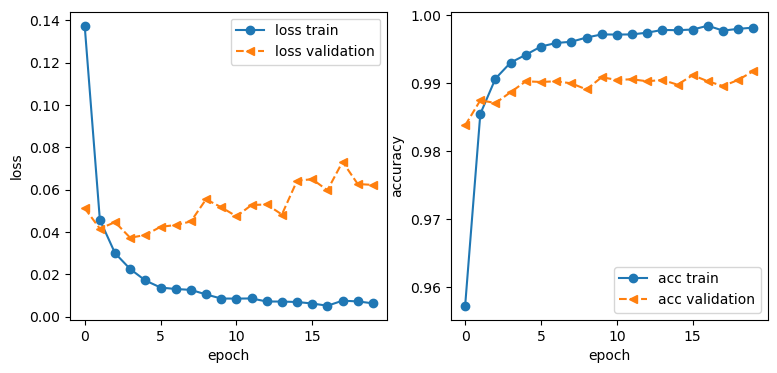

In [18]:
import matplotlib.pyplot as plt
import numpy as np

hist = history.history
x = np.arange(len(hist['loss']))

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(x, hist['loss'], '-o', label='loss train')
ax[0].plot(x, hist['val_loss'], '--<', label='loss validation')
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot(x, hist['accuracy'], '-o', label='acc train')
ax[1].plot(x, hist['val_accuracy'], '--<', label='acc validation')
ax[1].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

In [20]:
# оценка модели
test_results = model.evaluate(mnist_test.batch(20))
print('accuracy test: ', test_results[1], 'loss test:', test_results[0])

500/500 [==============================] - 2s 3ms/step - loss: 0.0354 - accuracy: 0.9929
accuracy test:  0.992900013923645 loss test: 0.03543476387858391


In [23]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])
tf.print(preds.shape)

TensorShape([12, 10])


In [24]:
preds = tf.argmax(preds, axis=1)
print(preds)

tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


Вывод первых картинок:

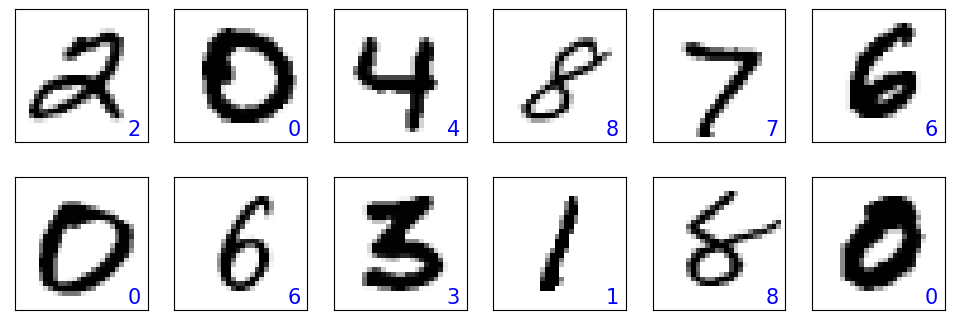

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, f'{preds[i]}',
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

Вывод неправильно классифицированных картинок:

In [79]:
xy_test = list(mnist_test.take(-1).as_numpy_iterator())
x_test = np.array(list(map(lambda item: item[0], xy_test)))

In [80]:
test_preds = model.predict(x_test)

In [81]:
y_preds = tf.argmax(test_preds, axis=1)
y_test = np.array(list(map(lambda item: item[1], xy_test)))

In [87]:
y_preds

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [94]:
mis_img = x_test[y_test != y_preds]
correct_label = y_test[y_test != y_preds]
mis_label = y_preds[y_test != y_preds]

In [98]:
mis_img.shape

(71, 28, 28, 1)

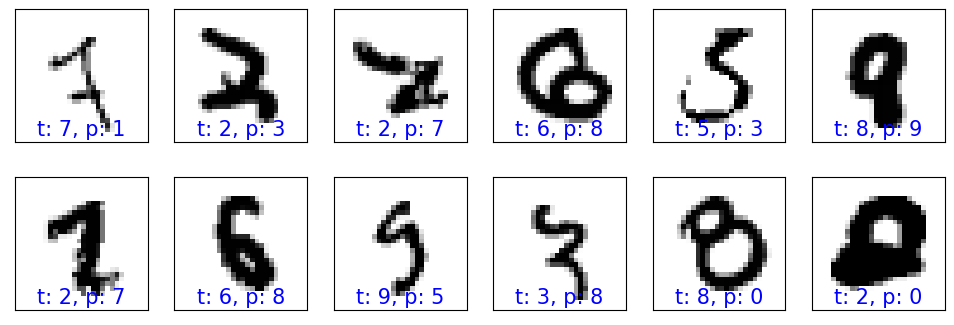

In [100]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mis_img[i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.5, 0.1, f't: {correct_label[i]}, p: {mis_label[i]}',
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

#### Классификация полов по изображениям лиц